# **INSTALASI & SETUP**

In [172]:
import warnings
warnings.filterwarnings('ignore')

In [173]:
!pip install Sastrawi matplotlib wordcloud pandas seaborn gensim pyLDAvis scikit-learn

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from collections import Counter


In [175]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12


# **LOAD DATA**

In [176]:
try:
    df = pd.read_csv("/content/dataset_fix.csv")
    print(f">>> Data Berhasil Dimuat: {len(df)} lagu ditemukan.")
    df = df.dropna(subset=['Lirik'])
    df = df[df['Lirik'].str.strip() != '']
    print(f">>> Data Valid: {len(df)} lagu siap diproses.")
except FileNotFoundError:
    print("ERROR: File tidak ditemukan. Menggunakan Data Dummy.")


>>> Data Berhasil Dimuat: 200 lagu ditemukan.
>>> Data Valid: 200 lagu siap diproses.


# **PRE-PROCESSING**

**SLANG DICT**

In [177]:
slang_dict = {
    # Singkatan Umum
    'gak': 'tidak', 'nggak': 'tidak', 'tak': 'tidak', 'ga': 'tidak', 'kaga': 'tidak', 'ndak': 'tidak',
    'yg': 'yang', 'kalo': 'kalau', 'kl': 'kalau', 'krn': 'karena', 'karna': 'karena',
    'lo': 'kamu', 'lu': 'kamu', 'loe': 'kamu', 'gue': 'aku', 'gw': 'aku', 'ak': 'aku', 'aq': 'aku',
    'bgt': 'banget', 'dr': 'dari', 'sdh': 'sudah', 'dgn': 'dengan', 'thd': 'terhadap',
    'aja': 'saja', 'jgn': 'jangan', 'tdk': 'tidak', 'blm': 'belum', 'dlm': 'dalam',
    'utk': 'untuk', 'bkn': 'bukan', 'km': 'kamu', 'sy': 'saya', 'kmu': 'kamu',
    'tp': 'tapi', 'bila': 'apabila', 'n': 'dan', 'and': 'dan', 'ma': 'sama',
    'tlah': 'telah', 'takkan': 'tidak akan', 'kan': 'akan', 'tuk': 'untuk',
    'slalu': 'selalu', 'mlm': 'malam', 'sm': 'sama', 'kpn': 'kapan',
    # Kata Khas Lirik (Puitis/Singkatan Apostrof)
    "kut'rima": "aku terima", "t'lah": "telah", "kuingin": "aku ingin",
    "s'lamanya": "selamanya", "s'lalu": "selalu", "b'ri": "beri",
    "kau": "engkau", "ku": "aku", "mu": "kamu", "dirimu": "diri kamu",
    "cinta": "cinta", "sayang": "sayang",
    # Bahasa Gaul 2020an (Opsional, jika ada di dataset)
    'bestie': 'teman', 'insecure': 'cemas', 'healing': 'sembuh', 'vibes': 'suasana',
    'baper': 'perasaan', 'mager': 'malas', 'gabut': 'bosan', 'halu': 'khayal'
}

# **STOPWORDS**

In [178]:
factory_stop = StopWordRemoverFactory()
sastrawi_stopwords = factory_stop.get_stop_words()

In [179]:
lyric_structure_words = [
    'reff', 'verse', 'chorus', 'intro', 'outro', 'bridge', 'interlude', 'pre', 'hook',
    'solo', 'guitar', 'instrumental', 'fade', 'ending', 'coda'
]

In [180]:
filler_words = [
    'la', 'na', 'ya', 'oh', 'ooh', 'woah', 'yeah', 'baby', 'feat', 'music', 'lyrics',
    'produced', 'by', 'nan', 'lala', 'yeyeye', 'uuu', 'aaa', 'hmm', 'hey', 'hi', 'ha',
    'hu', 'du', 'da', 'di', 'doo', 'shalala'
]

In [181]:
custom_stopwords = set(sastrawi_stopwords + lyric_structure_words + filler_words)

In [182]:
def clean_text_advanced(text):
    if pd.isna(text): return ""

    # 1. Pembersihan Struktur Data
    text = str(text).replace(':newline:', ' ')
    text = re.sub(r'\[.*?\]', '', text) # Hapus [Chorus]
    text = re.sub(r'\(.*?\)', '', text) # Hapus (Verse 1)

    # 2. Pembersihan Clitic/Apostrof (PENTING UNTUK LIRIK)
    text = text.replace("'", "")

    # 3. Filter Karakter (Hanya Huruf)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # 4. Case Folding & Spasi
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    words = text.split()
    processed_words = []

    for w in words:
        # 5. Normalisasi Slang
        w = slang_dict.get(w, w)

        # 6. Handling Clitic "ku-" dan "-mu" "nya" (Sederhana)
        # Misal "cintamu" -> "cinta", "kuberi" -> "beri"
        if w.endswith('mu') and len(w) > 4: w = w[:-2]
        if w.endswith('ku') and len(w) > 4: w = w[:-2]
        if w.endswith('nya') and len(w) > 5: w = w[:-3]
        if w.startswith('ku') and len(w) > 4: w = w[2:]

        # 7. Penghapusan Stopword
        if w not in custom_stopwords and len(w) > 2:
            processed_words.append(w)

    return " ".join(processed_words)


In [183]:
df['Lirik_Clean'] = df['Lirik'].apply(clean_text_advanced)
print(">>> Preprocessing Selesai. Contoh hasil:")
print(df[['Judul', 'Lirik_Clean']].head(5))

>>> Preprocessing Selesai. Contoh hasil:
            Judul                                        Lirik_Clean
0          Dan...  apabila esok datang sedia kala engkau bercanda...
1     Aku Milikmu  terdengar lirih bisikan diantara bayang bayang...
2      Matahariku  gelap kehidupan seakan tiada sinar cahaya coba...
3  Pergilah Kasih  pernah sangka terjadi kisah cinta suci engkau ...
4           Sobat  sobat aku sungguh mengerti semua terjadi perke...


**EKSTRAKSI FITUR & VISUALISASI KATA**

In [184]:
def get_top_words(text_series, n=10):
    all_words = " ".join(text_series).split()
    return Counter(all_words).most_common(n)


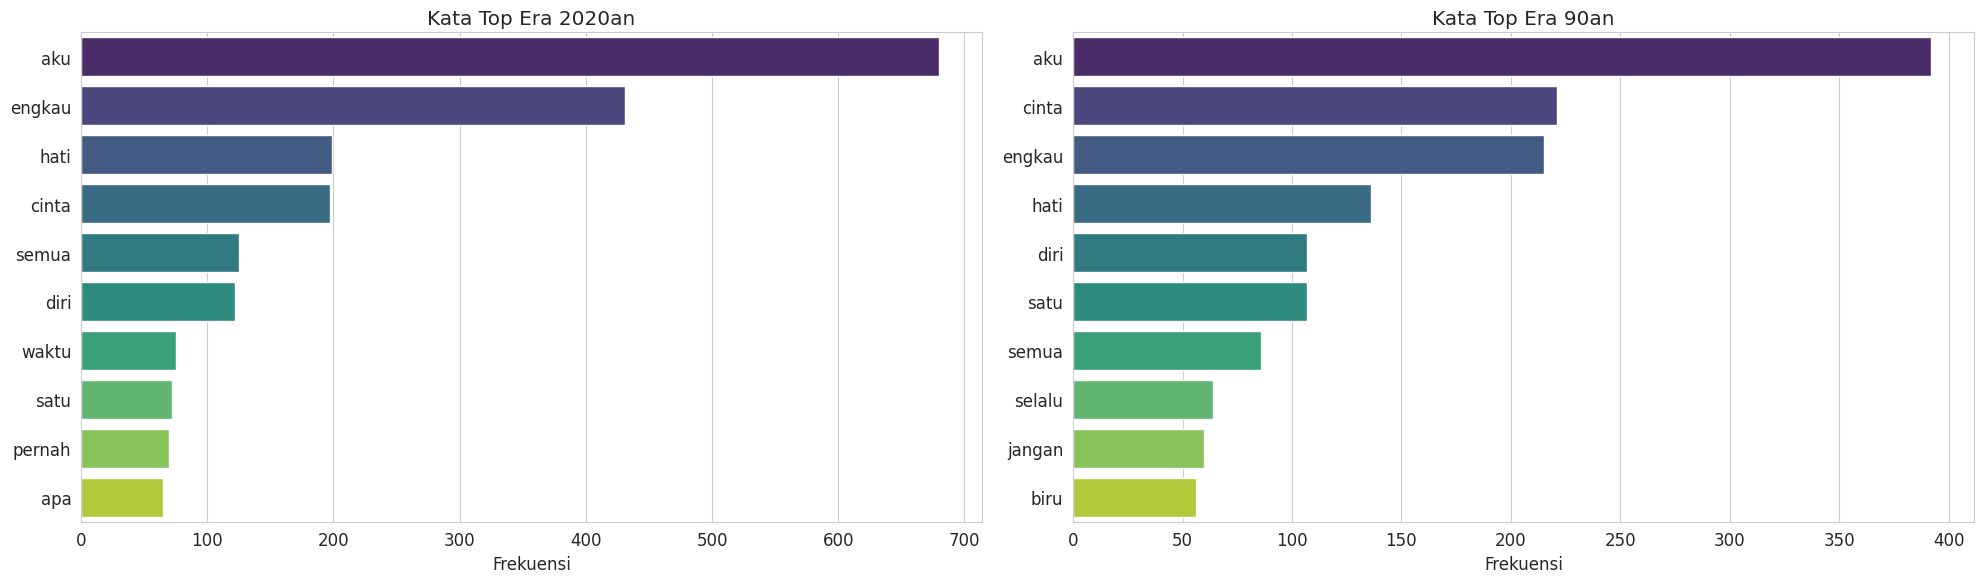

In [185]:
def get_top_words(text_series, n=10):
    all_words = " ".join(text_series).split()
    return Counter(all_words).most_common(n)

# 1. Tentukan Era
if 'Era' not in df.columns:
    import random
    df['Era'] = [random.choice(['90-an', '2000-an', '2010-an', '2020-an']) for _ in range(len(df))]
eras = sorted(df['Era'].unique())

# 2. Setup Canvas & Gambar
fig, axes = plt.subplots(1, len(eras), figsize=(20, 6))
if len(eras) == 1: axes = [axes]

for i, era in enumerate(eras):
    lirik_era = df[df['Era'] == era]['Lirik_Clean']
    top_words = get_top_words(lirik_era)

    if not top_words: continue

    sns.barplot(x=[x[1] for x in top_words], y=[x[0] for x in top_words], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Kata Top Era {era}')
    axes[i].set_xlabel('Frekuensi')

plt.tight_layout()
plt.show()

**WORDCLOUD**

MENAMPILKAN WORD CLOUD PER ERA


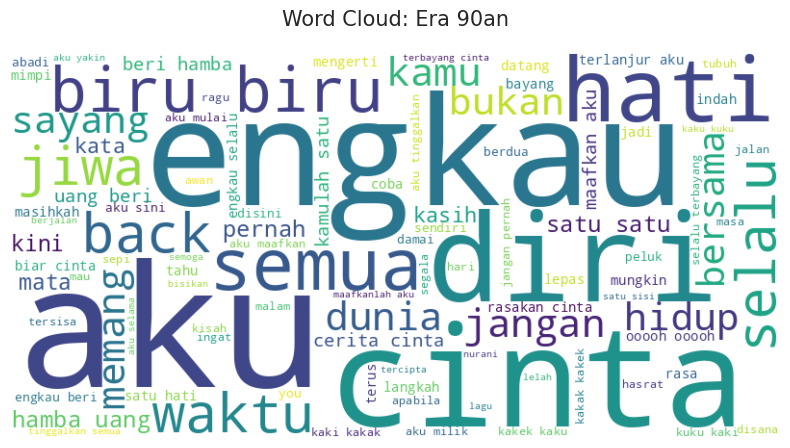

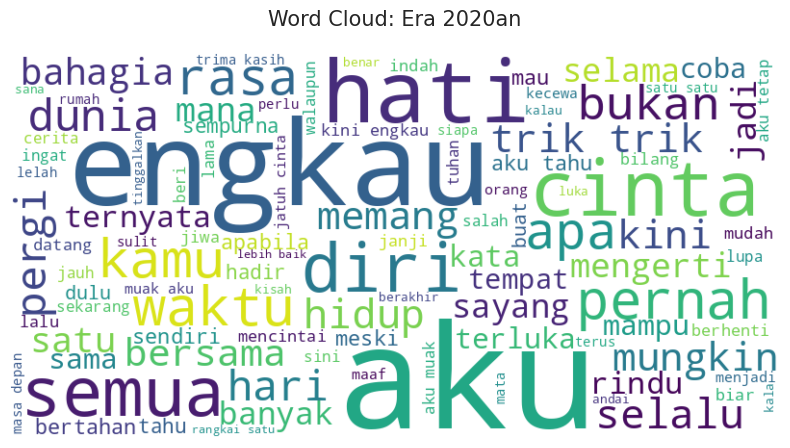

In [186]:
from wordcloud import WordCloud


def generate_wordcloud(text_series, title):
    text = " ".join(text_series.astype(str))

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords,
        colormap='viridis',
        min_word_length=3,
        max_words=100
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {title}', fontsize=15, pad=20)
    plt.show()

unique_eras = df['Era'].unique()

print("MENAMPILKAN WORD CLOUD PER ERA")
for era in unique_eras:
    subset = df[df['Era'] == era]['Lirik_Clean']
    if len(subset) > 0:
        generate_wordcloud(subset, f"Era {era}")
    else:
        print(f"Data untuk era {era} tidak cukup.")

In [187]:
tfidf = TfidfVectorizer(max_features=2000, min_df=2, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(df['Lirik_Clean'])


# **TOPIC MODELING (LDA)**

In [188]:
data_words = [text.split() for text in df['Lirik_Clean']]
id2word = corpora.Dictionary(data_words)
id2word.filter_extremes(no_below=2, no_above=0.7)
corpus = [id2word.doc2bow(text) for text in data_words]


In [189]:
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=42, passes=10, alpha='auto')


In [190]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f'\nCoherence Score: {coherence_lda:.4f}')
print("(Rentang nilai 0-1. Semakin tinggi, topik semakin mudah dimengerti manusia)")


Coherence Score: 0.3863
(Rentang nilai 0-1. Semakin tinggi, topik semakin mudah dimengerti manusia)


In [191]:
topic_labels = {
    0: "Hubungan & Kebersamaan",
    1: "Kenangan & Waktu",
    2: "Penyesalan/Religi (Hamba)",
    3: "Harapan & Mimpi",
    4: "Introspeksi Jiwa"
}

print("\n>>> KESIMPULAN TOPIK (INTERPRETASI):")
for idx, topic in lda_model.print_topics(-1):

    label = topic_labels.get(idx, f"Topik {idx+1}")

    clean_topic = re.sub(r'0\.\d+\*', '', topic)
    clean_topic = clean_topic.replace(' + ', ', ').replace('"', '')

    print(f" Topik {idx+1}: {label.upper()}")
    print(f"   Kata Kunci: {clean_topic}")
    print("-" * 50)


>>> KESIMPULAN TOPIK (INTERPRETASI):
 Topik 1: HUBUNGAN & KEBERSAMAAN
   Kata Kunci: cinta, engkau, hati, diri, ka, semua, bukan, jangan, mungkin, bersama
--------------------------------------------------
 Topik 2: KENANGAN & WAKTU
   Kata Kunci: engkau, semua, hati, cinta, satu, waktu, pernah, sama, selalu, dunia
--------------------------------------------------
 Topik 3: PENYESALAN/RELIGI (HAMBA)
   Kata Kunci: engkau, beri, terlanjur, hati, uang, semua, hamba, diri, kaki, jadi
--------------------------------------------------
 Topik 4: HARAPAN & MIMPI
   Kata Kunci: satu, cinta, hati, engkau, selalu, semua, mimpi, kamulah, mengerti, apabila
--------------------------------------------------
 Topik 5: INTROSPEKSI JIWA
   Kata Kunci: cinta, engkau, diri, hati, rasakan, malam, ka, ingin, jiwa, langkah
--------------------------------------------------


# **EMOTION LEXICON**

In [192]:
def analyze_emotion_advanced(text):
    scores = {k: 0 for k in emotion_lexicon_advanced.keys()}
    words = text.split()

    for i, w in enumerate(words):
        is_negated = False
        if i > 0 and words[i-1] in negation_words: is_negated = True

        for emo, keywords in emotion_lexicon_advanced.items():
            if w in keywords:
                if is_negated:
                    scores[emo] -= 1
                else:
                    scores[emo] += 1
    return pd.Series(scores)


In [193]:
emo_df = df['Lirik_Clean'].apply(analyze_emotion_advanced)
df = pd.concat([df, emo_df], axis=1)


In [194]:
era_emotions = df.groupby('Era')[list(emotion_lexicon_advanced.keys())].mean()
categories = list(era_emotions.columns)
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]


In [195]:
emotion_lexicon_final = {
    # --- POSITIVE ---
    'cinta': {'Joy': 1, 'Trust': 1}, 'sayang': {'Joy': 1, 'Trust': 1},
    'kasih': {'Joy': 1, 'Trust': 1}, 'bahagia': {'Joy': 1}, 'senang': {'Joy': 1},
    'percaya': {'Trust': 1}, 'setia': {'Trust': 1}, 'janji': {'Trust': 1},
    'kagum': {'Surprise': 1}, 'wow': {'Surprise': 1}, 'hebat': {'Surprise': 1},
    'semangat': {'Joy': 1, 'Anticipation': 1}, 'harapan': {'Anticipation': 1},

    # --- NEGATIVE ---
    'benci': {'Anger': 1, 'Disgust': 1}, 'muak': {'Disgust': 1, 'Anger': 1},
    'jijik': {'Disgust': 1}, 'najis': {'Disgust': 1}, 'palsu': {'Disgust': 1},
    'sakit': {'Sadness': 1, 'Fear': 1}, 'pedih': {'Sadness': 1}, 'luka': {'Sadness': 1},
    'takut': {'Fear': 1}, 'seram': {'Fear': 1}, 'gelap': {'Fear': 1},
    'mati': {'Fear': 1, 'Sadness': 1}, 'marah': {'Anger': 1}, 'kesal': {'Anger': 1},
    'hancur': {'Sadness': 1}, 'sepi': {'Sadness': 1, 'Fear': 1},

    # --- AMBIGU/LAINNYA ---
    'rindu': {'Sadness': 1, 'Anticipation': 1}, 'harap': {'Anticipation': 1},
    'mungkin': {'Anticipation': 1}, 'nanti': {'Anticipation': 1},
    'pulang': {'Anticipation': 1}, 'pergi': {'Sadness': 1},
    'hilang': {'Sadness': 1, 'Fear': 1}, 'tiba': {'Surprise': 1}, 'kaget': {'Surprise': 1}
}

# 2. Fungsi Hitung Skor
def analyze_emotion_final(text):
    scores = {'Joy': 0, 'Trust': 0, 'Fear': 0, 'Surprise': 0,
              'Sadness': 0, 'Disgust': 0, 'Anger': 0, 'Anticipation': 0}
    if isinstance(text, str):
        words = text.split()
        for word in words:
            if word in emotion_lexicon_final:
                for emo, val in emotion_lexicon_final[word].items():
                    scores[emo] += val
    return pd.Series(scores)


old_cols = ['Joy (Bahagia)', 'Sadness (Sedih)', 'Anger (Marah)', 'Anticipation (Harap)',
            'Joy', 'Trust', 'Fear', 'Surprise', 'Sadness', 'Disgust', 'Anger', 'Anticipation']

df = df.drop(columns=[c for c in old_cols if c in df.columns], errors='ignore')


emotion_df = df['Lirik_Clean'].apply(analyze_emotion_final)
df = pd.concat([df, emotion_df], axis=1)
df.head(1)

,Judul,Artis,Tahun,Era,Genre,Penulis,Lirik,Genius ID,Genius Path,Api Path,...,Disgust (Jijik),Surprise (Terkejut),Joy,Trust,Fear,Surprise,Sadness,Disgust,Anger,Anticipation
0,Dan...,Sheila On 7,1999,90an,Indonesian Pop,Sheila On 7,"[Lirik ""Dan...""]:newline::newline:[Verse 1]:ne...",756719,/Sheila-on-7-dan-lyrics,/songs/756719,...,0,0,0,0,0,0,0,0,0,0


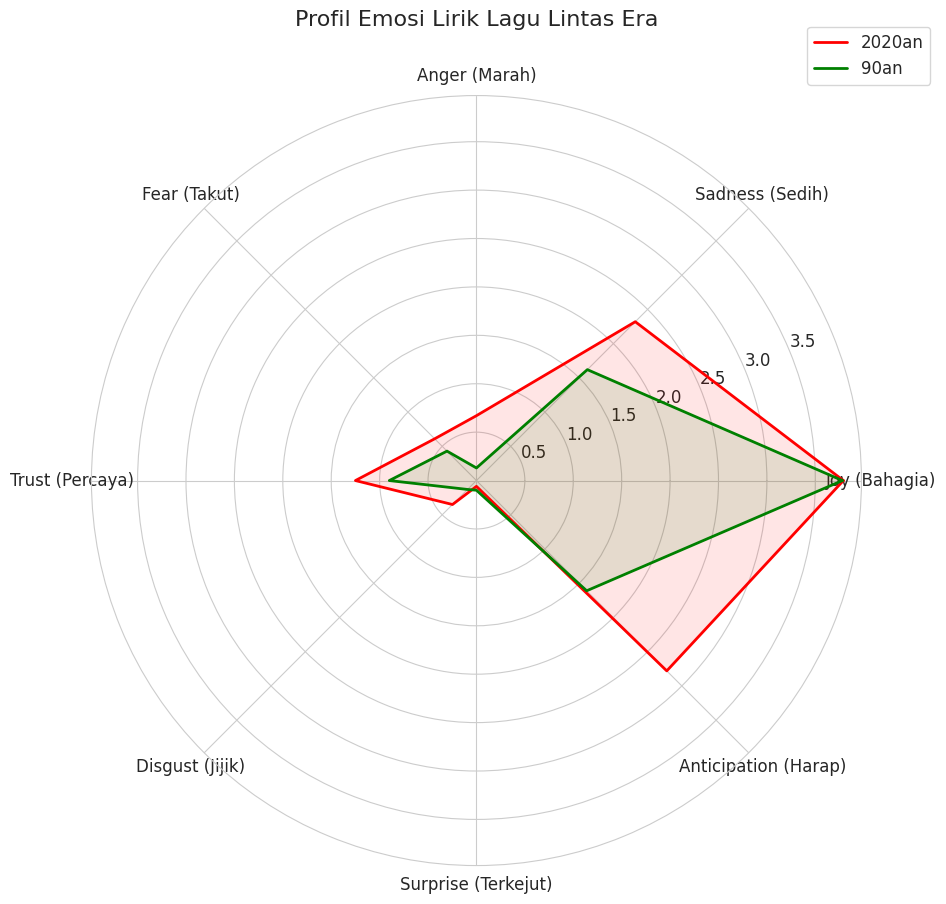

In [196]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
colors = ['r', 'g', 'b', 'y', 'm']
for i, era in enumerate(era_emotions.index):
    values = era_emotions.loc[era].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=era, color=colors[i % len(colors)])
    ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])
plt.xticks(angles[:-1], categories)
plt.title('Profil Emosi Lirik Lagu Lintas Era', y=1.08, fontsize=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

HALL OF FAME

In [197]:
def print_spotlight(emotion_col, label_keren):
    if emotion_col in df.columns:
        if df[emotion_col].max() > 0:
            song = df.loc[df[emotion_col].idxmax()]
            print(f"\n [KATEGORI: {label_keren}]")
            print(f"   Lagu Paling '{emotion_col}'")
            print(f"    Judul : {song['Judul']} - {song['Artis']}")
            print(f"    Skor  : {song[emotion_col]}")
        else:
            print(f"\n [KATEGORI: {label_keren}] - Data kosong (Skor 0). Coba tambah kata di kamus.")
    else:
        print(f" ERROR: Kolom '{emotion_col}' tidak ditemukan di DataFrame.")

print("       HALL OF FAME: EMOSI LAGU INDONESIA")

# Panggil 8 Kategori
print_spotlight('Sadness',      'Si Paling Galau ')
print_spotlight('Joy',          'Si Paling Happy ')
print_spotlight('Anger',        'Si Paling Emosi ')
print_spotlight('Anticipation', 'Si Paling Berharap ')
print_spotlight('Trust',        'Si Paling Setia ')
print_spotlight('Fear',         'Si Paling Parno ')
print_spotlight('Surprise',     'Si Paling Plot Twist ')
print_spotlight('Disgust',      'Si Paling Ilfil ')

       HALL OF FAME: EMOSI LAGU INDONESIA

 [KATEGORI: Si Paling Galau ]
   Lagu Paling 'Sadness'
    Judul : Rindu Ku Rindu - Mahalini
    Skor  : 14

 [KATEGORI: Si Paling Happy ]
   Lagu Paling 'Joy'
    Judul : Cerita Cinta - Kahitna
    Skor  : 21

 [KATEGORI: Si Paling Emosi ]
   Lagu Paling 'Anger'
    Judul : Muak - Aruma
    Skor  : 14

 [KATEGORI: Si Paling Berharap ]
   Lagu Paling 'Anticipation'
    Judul : Rindu Ku Rindu - Mahalini
    Skor  : 19

 [KATEGORI: Si Paling Setia ]
   Lagu Paling 'Trust'
    Judul : Cerita Cinta - Kahitna
    Skor  : 21

 [KATEGORI: Si Paling Parno ]
   Lagu Paling 'Fear'
    Judul : Takut - Idgitaf
    Skor  : 12

 [KATEGORI: Si Paling Plot Twist ]
   Lagu Paling 'Surprise'
    Judul : Jiwa Yang Bersedih - Ghea Indrawari
    Skor  : 4

 [KATEGORI: Si Paling Ilfil ]
   Lagu Paling 'Disgust'
    Judul : Muak - Aruma
    Skor  : 14


# **CLUSTERING & SPOTLIGHT**

In [198]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(tfidf_matrix)


In [199]:
cluster_labels = {
    0: "Galau/Sedih",
    1: "Reflektif/Diri",
    2: "Romantis/Cinta",
    3: "Bahasa Inggris"
}

In [200]:
print(">>> KATA KUNCI & BOBOT TF-IDF PER CLUSTER:")

terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(4):
    nama_cluster = cluster_labels.get(i, "Tanpa Nama")

    print(f"\n Cluster {i+1}: {nama_cluster}")

    for ind in order_centroids[i, :5]:
        word = terms[ind]
        weight = kmeans.cluster_centers_[i, ind]
        print(f"   - {word}: {weight:.4f}")

>>> KATA KUNCI & BOBOT TF-IDF PER CLUSTER:

 Cluster 1: Galau/Sedih
   - aku: 0.1450
   - engkau: 0.0666
   - mencintai: 0.0437
   - pulang: 0.0423
   - rindu: 0.0350

 Cluster 2: Reflektif/Diri
   - aku: 0.1209
   - engkau: 0.1041
   - hati: 0.0539
   - diri: 0.0536
   - cinta: 0.0386

 Cluster 3: Romantis/Cinta
   - cinta: 0.0843
   - engkau: 0.0509
   - aku: 0.0483
   - satu: 0.0444
   - semua: 0.0414

 Cluster 4: Bahasa Inggris
   - the: 0.3123
   - love: 0.2645
   - you: 0.2067
   - now: 0.1668
   - more: 0.1454


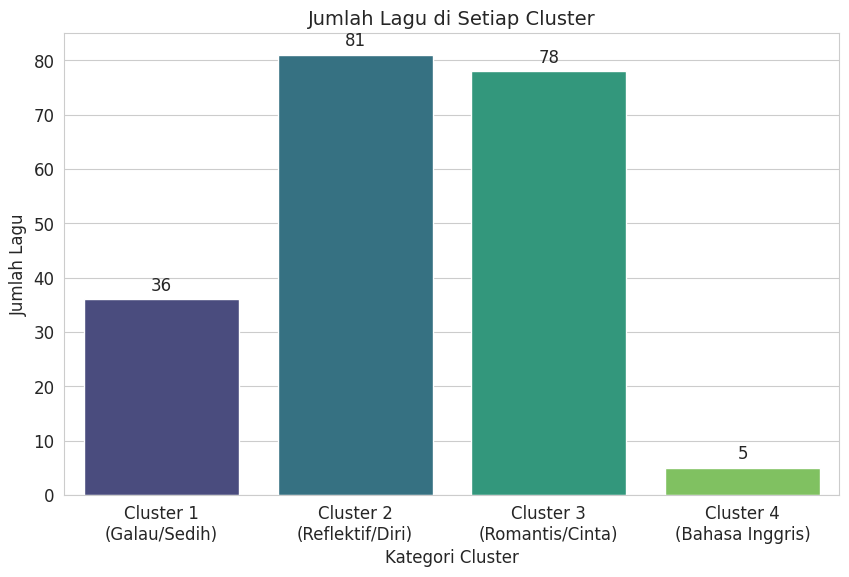


>>> CONTOH LAGU DI SETIAP CLUSTER:

 Cluster 1: Galau/Sedih
    Menari-nari
    Kemarin - Live
    Rantau
    Tentang Kamu
    Kau Rumahku

 Cluster 2: Reflektif/Diri
    Kita Usahakan Lagi
    Matahariku
    Sebelum Kau Terlelap
    Kisah Tanpa Dirimu
    Generasi Biru

 Cluster 3: Romantis/Cinta
    Suara Alam
    Aku Milikmu
    Satu Sisi
    Sudah
    Negeriku

 Cluster 4: Bahasa Inggris
    Still I'm Sure We'll Love Again
    everything u are
    Those Days Are Gone
    Bintang Kehidupan
    Making Love


In [201]:
df['Cluster_Label'] = df['Cluster'].map(lambda x: f"Cluster {x+1}\n({cluster_labels.get(x, 'Unknown')})")

plt.figure(figsize=(10, 6))

order_list = sorted(df['Cluster_Label'].unique())

ax = sns.countplot(x='Cluster_Label', data=df, order=order_list, palette='viridis')

plt.title('Jumlah Lagu di Setiap Cluster', fontsize=14)
plt.xlabel('Kategori Cluster', fontsize=12)
plt.ylabel('Jumlah Lagu', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

print("\n>>> CONTOH LAGU DI SETIAP CLUSTER:")

for i in range(4):
    nama_cluster = cluster_labels.get(i, "Tanpa Nama")
    print(f"\n Cluster {i+1}: {nama_cluster}")

    sample_songs = df[df['Cluster'] == i]['Judul'].sample(min(5, len(df[df['Cluster']==i])), random_state=42).values

    for lagu in sample_songs:
        print(f"    {lagu}")

**t-SNE**

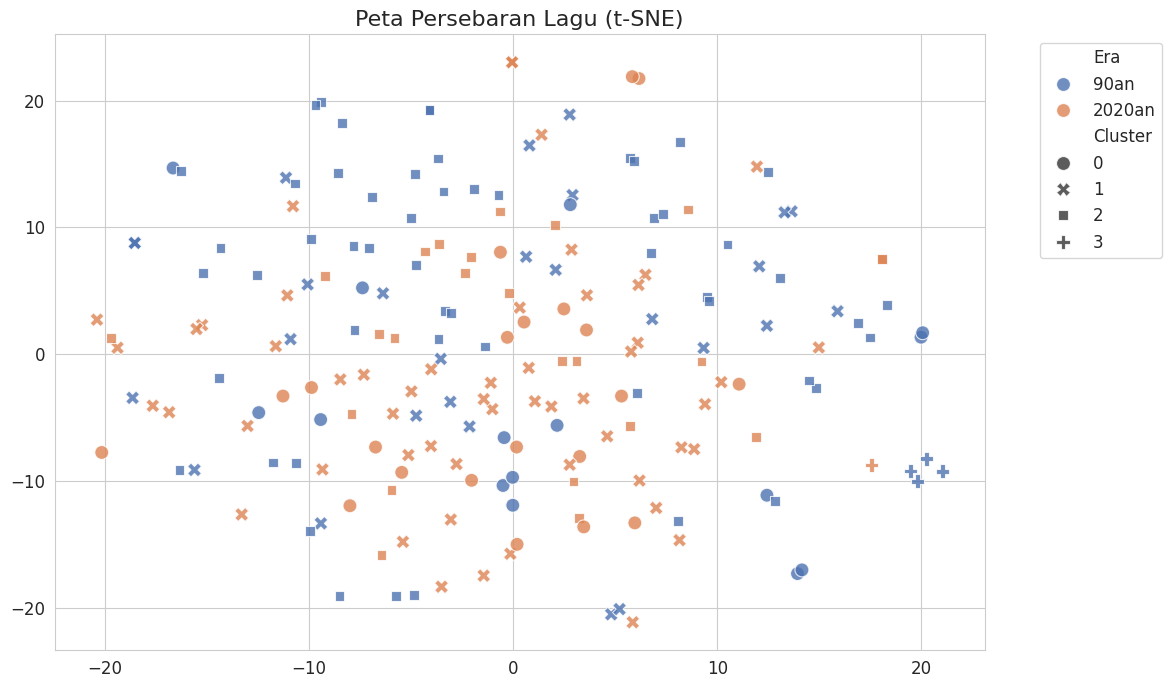

In [202]:
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df)-1))
    tsne_result = tsne.fit_transform(tfidf_matrix.toarray())
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=df['Era'], style=df['Cluster'], s=100, palette='deep', alpha=0.8)
    plt.title('Peta Persebaran Lagu (t-SNE)', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()
except Exception as e:
    print(f"Info: t-SNE skip ({e})")


**SAVE**

In [203]:
df.to_csv('hasil_analisis_lirik_final.csv', index=False)